# Introduction

This notebook demonstrates how to use the Vertex SDK to create video action recognition models using [AutoML](https://cloud.google.com/vertex-ai/docs/start/automl-users).

Specifically, we will be training and evaluating a model that recognizes volleyball serves.


## Objective

In this notebook, we evaluate the AutoML video action recognition model we trained in the first notebook. 

The steps performed include:

- View the model evaluation.
- Make a batch prediction.
- Make some gif images that indicates the prediction times.

Note: there is one key difference between using batch prediction and using online prediction:

* Prediction Service: Does an on-demand prediction for the entire set of instances (i.e., one or more data items) and returns the results in real-time.

* Batch Prediction Service: Does a queued (batch) prediction for the entire set of instances in the background and stores the results in a Cloud Storage bucket when ready.

# Setup

## Development environment setup

We'll need the following components:

0. ### GCPs:

- [Google Cloud project](https://console.cloud.google.com/cloud-resource-manager).
- [GCP billing](https://cloud.google.com/billing/docs/how-to/modify-project)
- [Enablement of the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)


1. ### Basics:
- Git
- Python 3
- pipenv

2. ### SDKs:
- Cloud Storage SDK
- AI Platform SDK

3. ###  Data and video analytic libraries :
- pandas
- numpy
- matplotlib
- OpenCV
- [MoviePy](https://zulko.github.io/moviepy/) for video editing


Note: if we are running this notebook on Vertex AI Workbench, our environment already meets the requirements 1 and 2 above.

## Authenticate Google Cloud account (for local only)



**If we are using Vertex AI Notebooks**, your environment is already authenticated. Skip this step.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# This provides access to our Cloud Storage bucket and lets us submit training jobs and prediction
# requests.
import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

# <font color='red'>Global Parameters</font>

<font color='red'> This section sets the global parameters for the downstream sections. Always run the cells in this section even if you're only running the later section (e.g. prediction)

### Project ID

In [2]:
PROJECT_ID = "sharp-leaf-344111"  # @param {type:"string"}

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)
else:
    print("Project ID:", PROJECT_ID)

Project ID: sharp-leaf-344111


In [26]:
# only run if it is local
! gcloud config set project $PROJECT_ID

Are you sure you wish to set property [core/project] to sharp-leaf-344111?

Do you want to continue (Y/n)?  ^C


Command killed by keyboard interrupt



### Region

We can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. To start with, we will be using  `europe-west4` as it is the closest to Nagra. The following regions are also available for Vertex AI:

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

Note: we may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services. (learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations))

In [4]:
REGION = "us-central1"  

### GCS bucket

When we initialize the Vertex SDK for Python, we specify a Cloud Storage staging bucket, into which all data associated with our dataset and model resources will be saved. Set the name of our GCS below.

In [6]:
BUCKET_NAME = "gs://aliz_action_recognition_poc"  # @param {type:"string"}

**Only if the bucket doesn't already exist**: Run the following cell to create a new Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Validate access to the bucket by examining its contents:

In [7]:
! gsutil ls -al $BUCKET_NAME

 376743798  2022-03-31T17:13:44Z  gs://aliz_action_recognition_poc/Aspire_11_vs_AZ_Sky_11_Gold_2022-02-05.mp4#1648746824256424  metageneration=1
 367656178  2022-03-31T17:13:43Z  gs://aliz_action_recognition_poc/Aspire_15_vs_SG_Elite__2022-02-21.mp4#1648746823872950  metageneration=1
    101022  2022-04-21T14:59:17Z  gs://aliz_action_recognition_poc/Nagra - training.csv#1650553157400516  metageneration=1
 771812506  2022-03-22T07:48:19Z  gs://aliz_action_recognition_poc/RVA_16P_vs_OJVA.mp4#1647935299871660  metageneration=1
     34104  2022-03-23T18:21:05Z  gs://aliz_action_recognition_poc/sample.csv#1648059665898925  metageneration=1
       173  2022-03-31T18:52:01Z  gs://aliz_action_recognition_poc/test.json#1648752721716317  metageneration=1
       117  2022-03-31T18:47:27Z  gs://aliz_action_recognition_poc/test.jsonl#1648752447798314  metageneration=1
       168  2022-04-04T19:29:30Z  gs://aliz_action_recognition_poc/test_1.json#1649100570728275  metageneration=1
     77825  2022-0

### Vertex SDK Initialization

Initialize the Vertex SDK for Python for our project and corresponding bucket.

In [13]:
import google.cloud.aiplatform as aiplatform
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)
import pandas as pd

# Evaluation 

After our model has finished training, we can retrieve its evaluation metrics.

First, we'll need to get a reference to the new model. Using the name of the model (constructed using `PREFIX` and `TRAINING_TIMESTAMP`, we'll grab the name of the model.

In [9]:
# Note: adjust the correct training timestamp to choose different model versions 
# You can also find these information in the UI.
#-------------------------------------------------------------------------------
PREFIX = "volley_"
TRAINING_TIMESTAMP = "20220320155122"
#-------------------------------------------------------------------------------

# Get model resource ID
models = aiplatform.Model.list(filter="display_name=" + PREFIX + TRAINING_TIMESTAMP)
model = models[0]
# Get a reference to the Model Service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aiplatform.gapic.ModelServiceClient(
    client_options=client_options
)

model_evaluations = list(model_service_client.list_model_evaluations(
    parent=models[0].resource_name
))

model_evaluation = model_evaluations[0]

# The model_evaluation object contains the information related to our model's performance.
print(model_evaluation)

name: "projects/276875326730/locations/us-central1/models/4028773331892174848/evaluations/5813827435929534464"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/video_action_recognition_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "evaluatedActionCount"
      value {
        number_value: 97.0
      }
    }
    fields {
      key: "videoActionMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.99999976
                          }
                        }
                        fields {
                          key: "f1Score"
                          valu

In [71]:
# Examples as to how to get specific metric values
model_evaluation.metrics["videoActionMetrics"][2]["precisionWindowLength"] # the "0" here refers to the different precision window length. 0 = 1s, 1 = 1s, 2 = 2s
model_evaluation.metrics["videoActionMetrics"][2]["confidenceMetrics"][0]["recall"] # choose among 'confidenceThreshold', 'recall', 'f1Score', 'precision'

0.010309278

# Prediction

In this section, we'll perform a batch prediction to using our deployed model.

### Get test item(s)

Now do a batch prediction to your Vertex model.

First, input the list of video(s) on which you'd like to evaluate your model. 

We grab some videos for testing from the import file that we used during training.

In [19]:
import_file = pd.read_csv("gs://aliz_action_recognition_poc/training_expanded.csv", header = None)
COLUMNS = ["train_test_split", "gcs_url", "start", "end", "action", "timestamp"]
import_file.columns = COLUMNS
import_file.head()

,train_test_split,gcs_url,start,end,action,timestamp
0,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,365
1,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,380
2,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,401
3,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,427
4,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,459


In [41]:
test_videos = import_file.loc[import_file["train_test_split"] == "test", "gcs_url"].unique()[:3]
test_videos

array(['gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4'],
      dtype=object)

In [42]:
print("The number of videos:")
print(len(test_videos))

The number of videos:
3


### Make a batch input file

Now make a batch input file, which you store in your local Cloud Storage bucket. The batch input file can be either CSV or JSONL. 

We will use JSONL. In the JSONL file, we'll make one dictionary entry per line for each video. The dictionary contains the key/value pairs:

- `content`: The Cloud Storage path to the video.
- `mimeType`: The content type. In our example, it is a `avi` file.
- `timeSegmentStart`: The start timestamp in the video to do prediction on. *Note*, the timestamp must be specified as a string and followed by s (second), m (minute) or h (hour).
- `timeSegmentEnd`: The end timestamp in the video to do prediction on.

In [43]:
# Here, we grab the ending time segment for each testing video from the `import_file` dataframe
time_segment_ends = []
for test_video in test_videos:
    time_segment_end = import_file.loc[import_file.gcs_url == test_video, "end"].values[0]
    time_segment_ends.append(time_segment_end)

In [44]:
import json
from google.cloud import storage

# specify start and end time segment
BUCKET_NAME = "gs://aliz_action_recognition_poc"
TIME_SEGMENT_START = "0.0"
FOLDER_NAME = "test_json" # the folder in the GCS bucket into which the test json files will be saved. Make sure it exists!

test_json_gcs_uris = []
for idx, (test_video, time_segment_end) in enumerate(zip(test_videos, time_segment_ends)):   
    
    # Configure the test-data, first as a dictionary
    data_dict = {
        "content": test_video,
        "mimeType": "video/avi",
        "timeSegmentStart": f"{TIME_SEGMENT_START}s",
        "timeSegmentEnd": f"{time_segment_end}s",
    }
    
    json_file = f"test_{idx + 1}.json"
    data_str = json.dumps(data_dict) + "\n" 

    # Upload the json to GCS bucket
    bucket = storage.Client(project=PROJECT_ID).bucket(BUCKET_NAME.replace("gs://", ""))
    blob = bucket.blob(blob_name=f"{FOLDER_NAME}/" +json_file)
    blob.upload_from_string(data_str)

    # Check if the json is uploaded to GCS successfully
    test_json_gcs_uri = BUCKET_NAME + f"/{FOLDER_NAME}/" + json_file
    print(f"{idx + 1}. The video '{test_video}' has been inputted into the test json '{test_json_gcs_uri}', whose content is as follows:")
    ! gsutil cat $test_json_gcs_uri
    
    
    test_json_gcs_uris.append(test_json_gcs_uri)

1. The video 'gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/test_1.json', whose content is as follows:


E0421 19:09:50.028446398   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8846717286329876480 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8423378921357049856 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/4235031267902488576 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/330410390972268544 current state:
JobState.JOB_STATE_RUNNING
{"content": "gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4", "mimeType": "video/avi", "timeSegmentStart": "0.0s", "timeSegmentEnd": "852s"}
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs

E0421 19:09:52.031859626   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{"content": "gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4", "mimeType": "video/avi", "timeSegmentStart": "0.0s", "timeSegmentEnd": "1608s"}
3. The video 'gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/test_3.json', whose content is as follows:


E0421 19:09:53.933788142   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{"content": "gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4", "mimeType": "video/avi", "timeSegmentStart": "0.0s", "timeSegmentEnd": "1241s"}
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8846717286329876480 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8426756621077577728 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/330410390972268544 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/4235031267902488576 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchP

### Make the batch prediction request

Now that your Model resource is trained, you can make a batch prediction by invoking the batch_predict() method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `gcs_destination_prefix`: The Cloud Storage location for storing the batch prediction resuls.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.


Note: you can't run too many batch prediction jobs at once or you'll get resource error! Do 3 at a time.

In [40]:
from datetime import datetime

PRED_TIMESTAMP = datetime.now().strftime("%Y/%m/%d_%H:%M:%S")


for idx, test_json_gcs_uri in enumerate(test_json_gcs_uris):
    print("="*45)
    print(f"Creating prediction job for video {idx + 1}:")
    print("="*45)
    batch_predict_job = model.batch_predict(
        job_display_name=PREFIX + PRED_TIMESTAMP+ f"_{idx+1}", # each video will get one predict job
        gcs_source=test_json_gcs_uri,
        gcs_destination_prefix=BUCKET_NAME,
        sync=False,
    )
    print(batch_predict_job)

Creating prediction job for video 1:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fedb4e36450> is waiting for upstream dependencies to complete.
Creating prediction job for video 2:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fedb4de7bd0> is waiting for upstream dependencies to complete.
Creating prediction job for video 3:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fedb4de3490> is waiting for upstream dependencies to complete.
Creating prediction job for video 4:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fedb4d50fd0> is waiting for upstream dependencies to complete.
Creating prediction job for video 5:
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<goog

INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/4235031267902488576 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/929389141412544512 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8423378921357049856 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/8846717286329876480 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/330410390972268544 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredi

Next, wait for the batch job to complete. Alternatively, one can set the parameter `sync` to `True` in the `batch_predict()` method to block until the batch prediction job is completed.

### Get the predictions

Next, get the results from the completed batch prediction job.




#### From `batch_predict_job`

The results are written to the Cloud Storage output bucket you specified in the batch prediction request. 

If we still have access to the `batch_predict_job`s we created earlier (i.e. we haven't shut down this notebook yet, we can call the method `iter_outputs()` to get a list of each Cloud Storage file generated with the results. Each file contains one or more prediction requests in a JSON format:

- `content`: The prediction request.
- `prediction`: The prediction response.
 - `id`: The internal assigned unique identifiers for each prediction request.
 - `displayName`: The class name for the predicted label.
 - `timeSegmentStart`: The time offset in the video to the start of the video sequence.
 - `timeSegmentEnd`: The time offset in the video to the end of the video sequence.
 - `confidence`: The predicted confidence, between 0 and 1.

In [55]:

bp_iter_outputs = batch_predict_job.iter_outputs()

pred_results = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction"):
        pred_results.append(blob.name)

pred_dicts = []
for idx, pred_result in enumerate(pred_results):
    gfile_name = f"gs://{bp_iter_outputs.bucket.name}/{pred_result}".replace(
        BUCKET_NAME + "/", ""
    )
    pred_dict = bucket.get_blob(gfile_name).download_as_string()
    pred_dict = json.loads(pred_dict)
    pred_dicts.append(pred_dict)
    with open(f"pred_{idx + 1}.json", 'w') as fp:
        json.dump(pred_dict, fp)
    print(f"Prediction {idx + 1} completed.")
    

'\nbp_iter_outputs = batch_predict_job.iter_outputs()\n\npred_results = list()\nfor blob in bp_iter_outputs:\n    if blob.name.split("/")[-1].startswith("prediction"):\n        pred_results.append(blob.name)\n\npred_dicts = []\nfor idx, pred_result in enumerate(pred_results):\n    gfile_name = f"gs://{bp_iter_outputs.bucket.name}/{pred_result}".replace(\n        BUCKET_NAME + "/", ""\n    )\n    pred_dict = bucket.get_blob(gfile_name).download_as_string()\n    pred_dict = json.loads(pred_dict)\n    pred_dicts.append(pred_dict)\n    with open(f"pred_{idx + 1}.json", \'w\') as fp:\n        json.dump(pred_dict, fp)\n    print(f"Prediction {idx + 1} completed.")\n'

#### From the UI

Otherwise:
- Go to the [batch predictions](https://console.cloud.google.com/vertex-ai/locations/us-central1/batch-predictions/8274472061607346176?project=sharp-leaf-344111) section of the Vertex UI
- Check your notes to see which prediction jobs correspond to which videos (you can also double check it from the input json indicated in the batch prediction job).
- Download, either via UI or gsutil, the `predictions.json` [(example)](https://console.cloud.google.com/storage/browser/aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-31T18:52:06.582487Z;tab=objects?project=sharp-leaf-344111&prefix=&forceOnObjectsSortingFiltering=false)

# Inspection

In this section, we'll manually inspect the content of the video(s), the "real" timestamps, and the predicted timestamps.

## Downloading of necessary files from GCS

In [49]:
DOWNLOAD_FOLDER = "test_video"
!mkdir $DOWNLOAD_FOLDER

mkdir: cannot create directory ‘test_video’: File exists


E0421 19:46:01.733908734   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [50]:
# copy the test videos locally so we can also inspect it
for test_video in test_videos: 
    !gsutil cp $test_video $DOWNLOAD_FOLDER

E0421 19:46:04.951922054   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4...
\ [1 files][ 87.6 MiB/ 87.6 MiB]                                                
Operation completed over 1 objects/87.6 MiB.                                     


E0421 19:46:08.201257893   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4...
/ [1 files][474.8 MiB/474.8 MiB]                                                
Operation completed over 1 objects/474.8 MiB.                                    


E0421 19:46:17.339069079   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4...
\ [1 files][295.2 MiB/295.2 MiB]                                                
Operation completed over 1 objects/295.2 MiB.                                    


In [57]:
!ls -la $DOWNLOAD_FOLDER

total 878256
drwxr-xr-x 2 jupyter jupyter      4096 Apr 21 19:46 .
drwxr-xr-x 5 jupyter jupyter      4096 Apr 21 19:55 ..
-rw-r--r-- 1 jupyter jupyter 309532778 Apr 21 19:46 Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4
-rw-r--r-- 1 jupyter jupyter 497911613 Apr 21 19:46 MxtuVgTAgnhtsDaqVF1.mp4
-rw-r--r-- 1 jupyter jupyter  91874521 Apr 21 19:46 Rukkus_vs__TVT_2022-01-22.mp4


E0421 19:55:26.410373327   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


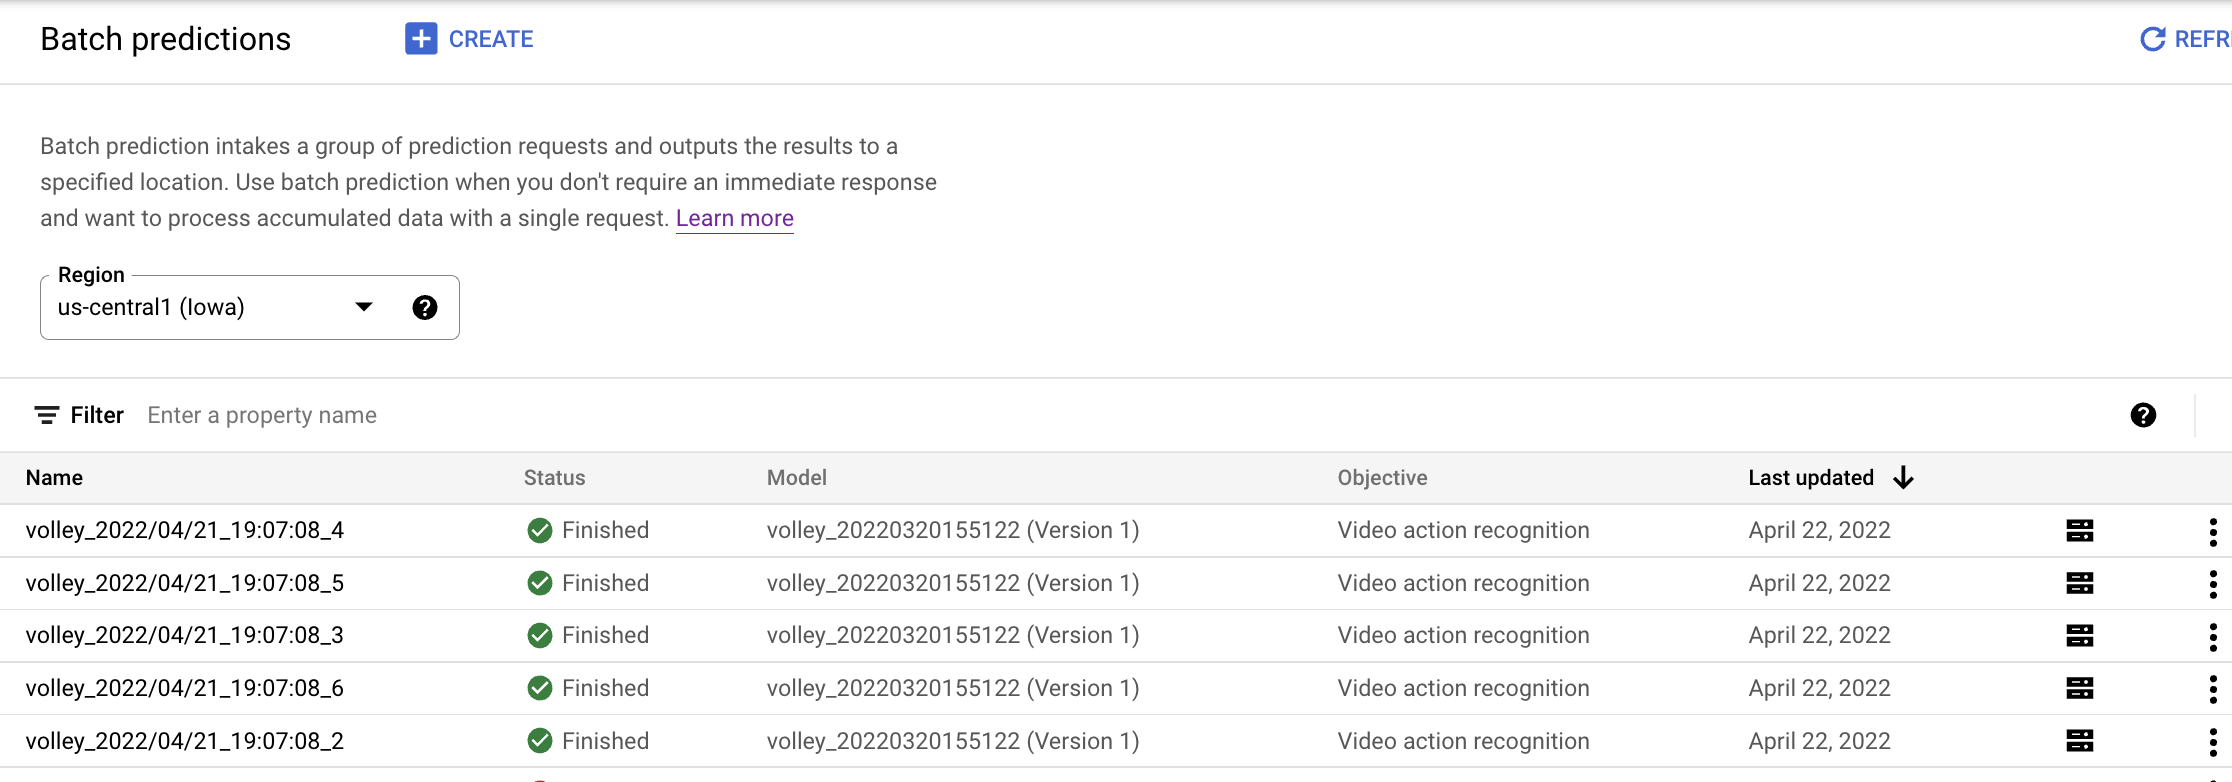

In [65]:
# Grab from the UI
prediction_json_urls = ["gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-04-21T19:07:09.144676Z/predictions_00001.jsonl",
                       "gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-04-21T19:07:09.090219Z/predictions_00001.jsonl"]
                

In [66]:
PREDICTION_JSON_FOLDER = "prediction_json"
!mkdir $PREDICTION_JSON_FOLDER

mkdir: cannot create directory ‘prediction_json’: File exists


E0421 20:04:24.660246691   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [70]:

renamed_prediction_json_files = []
for idx, url in enumerate(prediction_json_urls):
    renamed_prediction_json_file = f"prediction_{idx}.json"
    !gsutil cp $url $PREDICTION_JSON_FOLDER/$renamed_prediction_json_file
    renamed_prediction_json_files.append(PREDICTION_JSON_FOLDER + "/" + renamed_prediction_json_file)

E0421 20:05:50.891584047   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-04-21T19:07:09.144676Z/predictions_00001.jsonl...
/ [1 files][  4.5 KiB/  4.5 KiB]                                                
Operation completed over 1 objects/4.5 KiB.                                      


E0421 20:05:52.845431471   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_20220320155122-2022-04-21T19:07:09.090219Z/predictions_00001.jsonl...
/ [1 files][  5.5 KiB/  5.5 KiB]                                                
Operation completed over 1 objects/5.5 KiB.                                      


## Preprocessing

In [77]:
import numpy as np
import pandas as pd
import json

In [96]:
# We do two things:
# 1. Download the videos associated with the predictions
# 2. Create a dataframe 

results_dict = {}
for i in range(len(renamed_prediction_json_files)):
    with open(renamed_prediction_json_files[i]) as json_file:
        pred_label_dict = json.load(json_file)
        video_url = pred_label_dict["instance"]["content"]
        
        
        print("="*45)
        print(f"Video {i + 1}: {video_url}")
        print("="*45)
        
        
        # ----- download video -------
        !gsutil cp $video_url $DOWNLOAD_FOLDER

        # ----- get the predictions -------
        pred_label_df = pd.DataFrame.from_dict(pred_label_dict["prediction"])
        pred_label_df = pred_label_df.sort_values(by = "timeSegmentEnd",ascending = True)
        pred_label_df = pred_label_df.reset_index(drop = True)

        pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].str.replace(r"[a-zA-Z]",'')
        pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].astype(float)
        
        
        
        # ------ get the true labels ---------
        
        
        true_label_df = import_file.loc[import_file["gcs_url"] == video_url].copy()
        
        # --- get the result ----
        result_df = combine_true_pred_label(true_label_df, pred_label_df, eps = 2, max_time = 1000)
        
        
        
        results_dict[video_url] = result_df
        

Video 1: gs://aliz_action_recognition_poc/trunc_video/Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4


E0421 20:19:05.526049917   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4...
\ [1 files][338.3 MiB/338.3 MiB]                                                
Operation completed over 1 objects/338.3 MiB.                                    
Video 2: gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
E0421 20:19:11.553224436   14626 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4...
\ [1 files][295.2 MiB/295.2 MiB]                                                
Operation completed over 1 objects/295.2 MiB.                                    


In [99]:
pretty_display(results_dict[video_url])

,true_label,pred,confidence,label
0,nan,0.000000,0.991943,false positive
1,nan,21.000000,0.613105,false positive
2,nan,44.000000,0.544643,false positive
3,nan,56.000000,0.519666,false positive
4,nan,66.000000,0.751595,false positive
5,nan,140.000000,0.879021,false positive
6,nan,162.000000,0.722754,false positive
7,nan,169.000000,0.519805,false positive
8,nan,184.000000,0.817043,false positive
9,nan,196.000000,0.952178,false positive


In [91]:
def combine_true_pred_label(true_label_df, 
                            pred_label_df, 
                            eps = 1, 
                            true_label_col = "timestamp", 
                            pred_label_col = "timeSegmentEnd",
                            max_time = None):
    
    true_label_df = true_label_df.copy()
    true_label_df["prediction"] = None # create a new column for prediction
    
    for row in true_label_df.iterrows():
        index = row[0]
        true_timestamp = row[1][true_label_col]
        pred_timestamps = pred_label_df[pred_label_col]
        matching_pred = pred_label_df[abs(true_timestamp - pred_timestamps) <= eps][pred_label_col]
        if len(matching_pred) == 0:
            matching_pred = None
        elif len(matching_pred) > 1:
            raise ValueError(f'More than two predictions can be matched to the true timestamp at {true_row_timestamp}, consider decreasing the eps')
        else:
            true_label_df.at[index, "prediction"] = matching_pred.values[0]
            
    true_label_df["prediction"] =  true_label_df["prediction"].astype(float)
    result_df = pd.merge(true_label_df, pred_label_df, left_on='prediction', right_on=pred_label_col, how = "outer")
    result_df = result_df[[true_label_col, pred_label_col, "confidence"]]
    result_df.columns = ["true_label", "pred", "confidence"]
    
    # sort the rows of the result_df by the average betwen true_label and pred
    def get_average(true_label, pred):
        if pd.notnull(true_label) and pd.notnull(pred):
            return (true_label + pred)/2
        elif pd.notnull(true_label):
            return true_label
        else:
            return pred
    result_df["ave"] = result_df.apply(lambda x: get_average(x["true_label"], x["pred"]), axis = 1)
    result_df = result_df.sort_values(by = ["ave"], ascending = True)
    if max_time:
        result_df = result_df[result_df["ave"] <= max_time]
    result_df = result_df.drop("ave", axis = 1)
    
    
    def put_label(real, pred):
        if pd.notnull(real) and pd.notnull(pred):
            return "true positive"
        elif pd.notnull(real):
            return"false negative"
        else:
            return "false positive"
    result_df["label"] = result_df.apply(lambda x: put_label(x['true_label'], x['pred']), axis=1)
    result_df = result_df.reset_index(drop = True)

    
    return result_df
        

In [98]:


def pretty_display(result_df):
    def _highlight_cells(val):
        if val == "true positive":
            color = 'palegreen' 
        elif val == "false positive":
            color = "yellow"
        elif val == "false negative":
            color = "pink"
        else:
            color = ''

        return 'background-color: {}'.format(color)

    display(result_df.style.applymap(lambda x: 'color: red' if pd.isnull(x) else '').applymap(_highlight_cells))

## Manual precision/recall calculation

In [105]:
real_positive = result_df.notna().sum()["true_label"]
real_positive

12

In [106]:
pred_positive = result_df.notna().sum()["pred"]
pred_positive

36

In [107]:
true_positive = len(result_df[result_df.label == "true positive"])
true_positive

12

In [108]:
false_positive = len(result_df[result_df.label == "false positive"])
false_positive

24

In [109]:
false_negative = len(result_df[result_df.label == "false negative"])
false_negative

0

In [110]:
# Recall = True positive/Real positives
recall = true_positive/real_positive
recall

1.0

In [111]:
# Precision = True positive/Predicted positives
precision = true_positive/pred_positive
precision

0.3333333333333333

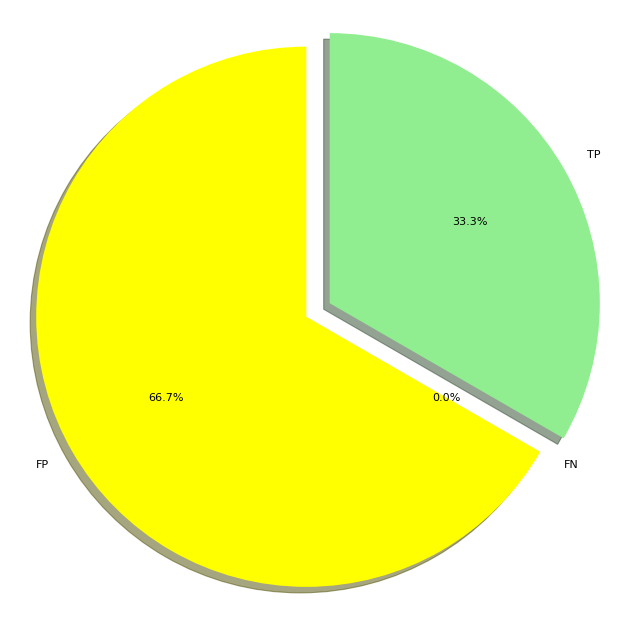

In [113]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'FP', 'FN', 'TP'
sizes = [false_positive, false_negative, true_positive]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(10, 10), dpi=80)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ["yellow","pink","lightgreen"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [41]:
comp_df.to_csv("comp_df.csv")

## Video inspection

In [76]:
# importing editor from movie py
from moviepy.editor import ColorClip, VideoFileClip, CompositeVideoClip, TextClip
  
# loading video dsa gfg intro video
clip = VideoFileClip("RVA_16P_vs_OJVA.mp4").subclip(0,5)
clip = clip.without_audio()

E0401 10:53:07.202539851   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.276007448   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.378620689   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0401 10:53:07.450068354   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [77]:
txt_clips = []
for timestamp in result_df["true_label"].tolist():
    if pd.notna(timestamp):
        txt_clip = TextClip("True serve", fontsize = 75, color = 'white')
        txt_clip = txt_clip.set_position(("left", "bottom")).set_start(timestamp).set_duration(3) 
        txt_clips.append(txt_clip)


txt_clips2 = []
for timestamp in result_df["pred"].tolist():
    if pd.notna(timestamp):
        txt_clip2 = TextClip("Pred serve", fontsize = 75, color = 'yellow')
        txt_clip2 = txt_clip2.set_position(("right", "bottom")).set_start(timestamp).set_duration(3) 
        txt_clips2.append(txt_clip2)
    
    

E0401 10:53:31.546144987   12689 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


OSError: MoviePy Error: creation of None failed because of the following error:

convert-im6.q16: attempt to perform an operation not allowed by the security policy `@/tmp/tmp9o3p4vx3.txt' @ error/property.c/InterpretImageProperties/3666.
convert-im6.q16: no images defined `PNG32:/tmp/tmpl719lq67.png' @ error/convert.c/ConvertImageCommand/3258.
.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or that the path you specified is incorrect

In [102]:
result = CompositeVideoClip([clip] + txt_clips + txt_clips2)
#result.set_duration(200).write_videofile("test.mp4" ,audio=False, fps=2)
result.subclip(2435, 2440).write_gif("false_pos2.gif", fps=15)

/bin/bash: rpm: command not found


E0323 19:17:22.345158890   17608 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [ ]:
# ask if its professional also
# do ppl actually have multiple cameras?
# evaluate model on more videos


In [1]:
!gsutil ls gs://aliz_action_recognition_poc/videos

gs://aliz_action_recognition_poc/videos/
gs://aliz_action_recognition_poc/videos/Fiesta_MLK_Tournament_Court_22_trunc.mp4
gs://aliz_action_recognition_poc/videos/RVA_16P_vs_OJVA.mp4


In [3]:
!gsutil mv gs://aliz_action_recognition_poc/trunc_videos/Fiesta_MLK_Tournament_Court_22_trunc.mp4 gs://aliz_action_recognition_poc/trunc_video/

Copying gs://aliz_action_recognition_poc/trunc_videos/Fiesta_MLK_Tournament_Court_22_trunc.mp4 [Content-Type=video/mp4]...
Removing gs://aliz_action_recognition_poc/trunc_videos/Fiesta_MLK_Tournament_Court_22_trunc.mp4...

Operation completed over 1 objects/2.5 GiB.                                      
